In [ ]:
import torch

It now works and gives you the best learning rate but when extracting the accuracy information, it gives get_itos() error. There should be 1 given parameter but 2 given. 

In [ ]:
torch.randn(5).cuda() #now Im running in GPU

tensor([-1.0300,  2.6010,  0.2278, -0.9498,  0.8444], device='cuda:0')

In [ ]:
pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412 kB 32.6 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 495 kB 67.2 MB/s 
     |████████████████████████████████| 162 kB 73.7 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 127 kB 68.4 MB/s 
     |████████████████████████████████| 162 kB 60.3 MB/s 
     |████████████████████████████████| 158 kB 72.6 MB/s 
     |████████████████████████████████| 157 kB 68.4 MB/s 
     |████████████████████████████████| 157 kB 75.8 MB/s 
     |████████████████████████████████| 157 kB 82.6 MB/s 
     |████████████████████████████████| 157 kB 45.2 MB/s 
     |████████████████████████████████| 157 kB 78.1 MB/s 
     |████████████████████████████████| 157 kB 74.5 MB/s 
     |█████████████████████████████

In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 35.6 MB/s 
     |████████████████████████████████| 181 kB 55.8 MB/s 
     |████████████████████████████████| 63 kB 824 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=43aaaba60cbce4d3dbae0b75ebcdc78a5096ea481216d3b223492cd3c45cc416
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 32.8 MB/s 
     |████████████████████████████████| 5.9 MB 58.7 MB/s 
     |████████████████████████████████| 529 kB 51.2 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.


In [ ]:
# # for logging 
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
#from pytorch_lightning.loggers import TestTubeLogger  #TestTubeLogger is deprecated in pytorch_lightning 1.7.0. Check the alternative logger class.
from pytorch_lightning.loggers import WandbLogger
import wandb
# For metrics
#from pytorch_lightning import metrics      # check the version of pytorch_lightning, I commented here since it is deprecated
from torchmetrics import metric
import math
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import io
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping # The EarlyStopping callback can be used to monitor a validation metric and stop the training when no improvement is observed.
from pytorch_lightning import seed_everything
from torchmetrics import ConfusionMatrix  #from pytorch_lightning import metrics has changed to torchmetrics
import itertools
seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [ ]:
from torchmetrics import Metric  # in 0.9.0 version, it works
#from pytorch_lightning.metrics.utils import _input_format_classification  # _input_format_classification cannot be found in the literature. Its name may be changed.
from sklearn.metrics import classification_report
class MyClassificationReport(Metric):
    def __init__(self,threshold: float = 0.5,compute_on_step: bool = True,dist_sync_on_step: bool = False):
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
        )

        self.threshold = threshold
        self.add_state("preds", default=[], dist_reduce_fx=None)
        self.add_state("target", default=[], dist_reduce_fx=None)

        # rank_zero_warn(
        #     'Metric `MyClassificationReport` will save all targets and predictions in buffer.'
        #     ' For large datasets this may lead to large memory footprint.'
        # )

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        preds = preds.cpu()
        target = target.cpu()
        y_hat, y = preds.max(1).indices, target
        assert y_hat.shape == y.shape
        self.preds.append(y_hat)
        self.target.append(y)

    def compute(self):
        preds = torch.cat(self.preds, dim=0)
        target = torch.cat(self.target, dim=0)

In [ ]:
from sklearn.model_selection import train_test_split

def getAlarmsSeqs(fname):  # returns the alarms in a list, no sequence blocks, to build vocab
    lines = None
    with open(fname) as f:
        lines = f.readlines()

    temp_alarms_seqs = []
    for i,line in enumerate(lines):
        seq = line.split()
        temp_alarms_seqs.append(seq)
    
    temp_alarms_seqs =  list(itertools.chain(*temp_alarms_seqs)) 


    return temp_alarms_seqs

class AlarmDataset(Dataset):
    def __init__(self,data,seq_len,batch_size):
        self.length = len(data)//seq_len # how much data i have         
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
       
    def __getitem__(self, index: int):
        x = self.data[index*self.seq_len:(index*self.seq_len)+self.seq_len]
        y = self.data[1+index*self.seq_len:1+(index*self.seq_len)+self.seq_len]
        return x,y
    
    def __len__(self) -> int:
        return self.length

class MyDataModule(pl.LightningDataModule):
    
    def __init__(self,config):
        super().__init__()
        self.config = config
        dir_path = self.config['dir-path']
        train_file_name = 'train_filtered.tokens'
        val_file_name = 'val_filtered.tokens'
        test_file_name = 'test_filtered.tokens'

        train = getAlarmsSeqs(dir_path+train_file_name)
        val = getAlarmsSeqs(dir_path+val_file_name)
        test = getAlarmsSeqs(dir_path+test_file_name)
        print(f"train_len: {len(train)}, val_len: {len(val)}, test_len: {len(test)}")

        tokens = []
        tokens.append(train)
        tokens.append(val)
        tokens.append(test)
        tokens = list(itertools.chain(*tokens))  #flatten all the tokens
        print("tokens:", tokens)

        self.tokenizer = get_tokenizer('basic_english')  #what is the reaon you tokenize as English?
        #self.vocab_train = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+train_file_name,encoding="utf8"))))
        #self.vocab_val = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+val_file_name,encoding="utf8"))))
        #self.vocab_test = build_vocab_from_iterator(map(self.tokenizer,iter(io.open(dir_path+test_file_name,encoding="utf8"))))
        #a vocabolary is built by using the train.tokens file
        # test and val dataset consist alarm names that is different from train set. That is why it gives such an error. 
        
        self.vocab = build_vocab_from_iterator(map(self.tokenizer,iter(tokens)))

        print(self.vocab.get_stoi())

        train_data = self.data_process(iter(io.open(dir_path +"train_filtered.tokens", encoding="utf8")))
        val_data = self.data_process(iter(io.open(dir_path +"val_filtered.tokens", encoding="utf8")))  #error happens here
        test_data = self.data_process(iter(io.open(dir_path +"test_filtered.tokens", encoding="utf8")))

    
        self.train_dataset = AlarmDataset(train_data, self.config['seq-len'], self.config['batch-size'])
        self.valid_dataset = AlarmDataset(val_data,self.config['seq-len'], self.config['batch-size'])
        self.test_dataset = AlarmDataset(test_data, self.config['seq-len'], self.config['batch-size'])

    
    def data_process(self, raw_text_iter):  # vocab[token] gives error since test and val dataset is not added to the vocab.
        data = [torch.tensor([self.vocab[token] for token in self.tokenizer(item)],dtype=torch.long) for item in raw_text_iter]
        return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))
    
    def get_weight_per_class(self):
        def lambdaFun(total,v,num_classes):
            if v>0:
                return total/(v*num_classes) 
            return 0
        
        #index2count in dict
        index_2_count = {i:0 for i in range(len(self.vocab))} #this is written by github copilot

        # get counts as frequencies using get_stoi() from vocab object
        for i in self.vocab.get_stoi().values():
            index_2_count[i] += 1

        # index_2_count = {self.vocab.stoi[k]:self.vocab.freqs[k]  for k in list(self.vocab.get_stoi())}
        total = sum(index_2_count.values())
        index_2_ws = {k:lambdaFun(total,v,len(index_2_count)) for k,v in index_2_count.items()}
        index_2_ws[1] = 0.0 # MANUALLY Setting the weights to zero for the padding
        # index_2_ws[0] = 0.0 # MANUALLY Setting the weights to zero for the padding
        ws = torch.tensor([index_2_ws[i] for i in range(len(index_2_ws))])

        return ws

    def prepare_data(self):
        """
            Use this method to do things that might write to disk or that need to be done only from a single GPU in distributed settings.
            e.g., download,tokenize,etc…
        """ 
        return None


    def setup(self, stage: None):
        """
            There are also data operations you might want to perform on every GPU. Use setup to do things like:
            count number of classes,build vocabulary,perform train/val/test splits,apply transforms (defined explicitly in your datamodule or assigned in init),etc…
        """
        return None

    def train_dataloader(self) -> DataLoader:  # number of workers is changed from 8 to 0
        return DataLoader(self.train_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=0,drop_last=True, pin_memory=True)
    
    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=0,drop_last=True, pin_memory=True)
    
    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.config['batch-size'], shuffle=False,num_workers=0,drop_last=True, pin_memory=True)


In [ ]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class TransformerModel(pl.LightningModule):

    def __init__(self, config):
        super(TransformerModel, self).__init__()
        self.accuraccy_50_count = 0
        self.config = config        
        self.lr = self.config["lr"]
        self.weight_decay = self.config["weight-decay"]
    
        self.pos_encoder = PositionalEncoding(self.config['em-size'], self.config['dropout'])
        encoder_layers = torch.nn.TransformerEncoderLayer(self.config['em-size'], self.config['nhead'], self.config['nhid'], self.config["dropout"])
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, self.config['nlayers'])
        self.encoder = torch.nn.Embedding(self.config["vocab-size"], self.config['em-size'])
        self.decoder = torch.nn.Linear(self.config['em-size'], self.config["vocab-size"])  #just one linear layer
        self.src_mask = self.generate_square_subsequent_mask(self.config['seq-len']) 
        self.init_weights()

        self.class_weight = self.config['weight_per_class']

        # self.train_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.val_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        # self.test_F1 = metrics.classification.F1(num_classes=self.config["vocab-size"],average = 'micro')
        
        self.val_CM_normalized = ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.val_CM_raw = ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.train_CM_normalized = ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')
        self.train_CM_raw = ConfusionMatrix(num_classes=self.config["vocab-size"])

        self.test_CM = ConfusionMatrix(num_classes=self.config["vocab-size"],normalize ='true')

        self.val_MCR = MyClassificationReport()
        self.test_MCR = MyClassificationReport()

        self.log("Sequence length",self.config['seq-len'])
        self.log("lr",self.lr)
        self.log("# of tokens/vocab_size (unique alarms)",self.config['vocab-size'])
        self.log("weight_decay",self.weight_decay)
        self.save_hyperparameters()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self): # initialize the weights to non zero number
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src_mask = src_mask.to(self.device)
        src = self.encoder(src) * math.sqrt(self.config['em-size'])
        src = self.pos_encoder(src)
      
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        
        return output

   # The ReduceLROnPlateau scheduler requires a monitor
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        d = {
       'optimizer': optimizer,
       'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=10, verbose=True),
       'monitor': 'val_epoch_loss',
        'interval': 'epoch'
        }
        return d 

    def loss_function(self,logits,y):
        return F.cross_entropy(logits,y,weight= self.class_weight,ignore_index=1) 

    def myPrintToFile(self,cm_normal,cm_raw,f):
        cm_normal = cm_normal.cpu()
        cm_raw = cm_raw.cpu()
        

        sum_of_each_class = cm_raw.sum(axis=1) # sum along the columns
        print(f"        ------ Epoch {self.current_epoch} ---------",file=f)
        print(f"Total={[v.item() for v in sum_of_each_class]}",file=f)
        print(f"Corret={[v.item() for v in torch.diagonal(cm_raw,0)]}",file=f)
        print(f"Accuracy={[round(v.item(),3) for v in (torch.diagonal(cm_raw,0)/sum_of_each_class)]}",file=f)

        accs = [round(v.item(),3)  for v in torch.diagonal(cm_normal,0)]
        print(accs)

        source2acc = {self.config['vocab'].get_itos(i):accs[i] for i in range(len(accs))}

        source2_acc50 = {self.config['vocab'].get_itos(i):accs[i] for i in range(len(accs)) if accs[i]>=0.5}

        print(f"Acc2={accs}",file=f)
        print(f"source2_acc= {source2acc}",file=f)
        print(f"source2_acc50= {source2_acc50}",file=f)

        a_50 = len([a for a in accs if a>=0.5])
        a_30 = len([a for a in accs if a>=0.3])
        out_str = f"acc>0.5= {a_50}, acc>=0.3= {a_30}, Total={len(accs)}"
        print(out_str,file=f)

        


        # if temp> self.accuraccy_50_count and train=:
        #     self.accuraccy_50_count = temp
        print(out_str,end=" ") 

      

    def training_step(self,batch,batch_idx):
        x,y = batch
        x = x.T # transpose
        y = y.T.reshape(-1)

        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask) # calling forward method
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y) # cross entropy itself compute softmax 

        self.train_CM_normalized(F.softmax(y_hat),y)
        self.train_CM_raw(F.softmax(y_hat),y)
        
        self.log('train_loss',loss,logger=True)
        # self.log('train_F1',self.train_F1(F.softmax(y_hat),y),logger=True)
        return loss

    def validation_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        
        if x.size(0) != self.config['seq-len']:
            # print(f">> passed {x.size()}")
            self.src_mask =  self.generate_square_subsequent_mask(x.size(0))
        
        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1, self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.val_MCR(F.softmax(y_hat),y)
        self.val_CM_normalized(F.softmax(y_hat),y)
        self.val_CM_raw(F.softmax(y_hat),y)

        self.log('val_loss',loss,logger=True)
        # self.log('val_F1',self.val_F1(F.softmax(y_hat) ,y),logger=True)
        return {'val_loss':loss}
    
    def test_step(self,batch, batch_idx):
        x,y = batch
        x = x.T
        y = y.T.reshape(-1)
        if x.size(0) != self.config['seq-len']:
           self.src_mask =  self.generate_square_subsequent_mask(x.size(0))

        y_hat = self(x,self.src_mask)
        y_hat =  y_hat.view(-1,  self.config['vocab-size'])
        loss = self.loss_function(y_hat,y)

        self.test_MCR(F.softmax(y_hat),y)
        self.log('test_loss',loss,logger=True)
        # self.log('test_F1', self.test_F1(F.softmax(y_hat) ,y),logger=True)
        return {'test_loss':loss}
    
    def training_epoch_end(self, outputs):

        avg_loss = torch.stack([d['loss']  for d in outputs]).mean()
        # f1 = self.train_F1.compute()
        print(f"[{self.current_epoch}]E, Avg Training loss = {round(avg_loss.item(),4)}",end=" ")
        """
        with open(self.config["train-file"],'a') as f:
            self.myPrintToFile(self.train_CM_normalized.compute(),self.train_CM_raw.compute(),f)
        self.log("train_epoch_loss",avg_loss,logger=True,prog_bar=True)
        # self.log("train_epoch_F1", f1, logger=True,prog_bar=True)
        """
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([d['val_loss'] for d in outputs]).mean()
        # f1 = self.val_F1.compute()
        # print(self.val_MCR.compute(),file=open("val-out.txt",'w'))
        # print(self.val_CM.compute(),file=open("val-cm-out.txt",'w'))

        # if self.current_epoch%4==0 and self.current_epoch>0:
        # self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute())

        """
        print(f"::Val Loss = {round(avg_loss.item(),4) }",end=" ")

        with open(self.config["val-file"],'a') as f:
            self.myPrintToFile(self.val_CM_normalized.compute(),self.val_CM_raw.compute(),f)
        
        print("")


        self.log("val_epoch_loss",avg_loss,logger=True)
        """
        # self.log("val_epoch_F1",f1,logger=True,prog_bar=True)
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([d['test_loss'] for d in outputs]).mean()
        # f1 = self.test_F1.compute()
        # print(self.test_MCR.compute(),file=open("test-out.txt",'w'))
        print(f">Average Test Loss = {avg_loss.item()}")
        self.log("test_epoch_loss",avg_loss, logger = True)
        # self.log("test_epoch_F1",f1, logger=True)
        
    

In [ ]:
def weightCondition(w,avg_w):
    if w<avg_w:
        return w
    else:
        return avg_w


In [ ]:
# setup data
config_data = {
'dir-path' : "/content/",
'batch-size' :512, # Batch Size 
'seq-len' :12, # Sequence length
}

In [ ]:
dm = MyDataModule(config=config_data)  # read train.tokens
ws = dm.get_weight_per_class().cuda()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{'47fi1504d': 215, '47ti1509': 214, '48fi012': 213, '47fic1701': 209, '47ti618': 207, '48aah007-ann': 203, '47ti1724': 202, '47ti1508': 201, '47lic1514': 200, '47aic003': 199, '47tic1551': 208, '48lic018': 198, '48fall2021-ann': 191, '47ti1551': 190, '47fic1502': 189, '47li850a': 187, '47fic1534': 185, '47pi1711': 181, '48xl008-ann': 180, '48ua012-ann': 178, '47fic1507': 177, '47fic012': 176, '47tah808-ann': 175, '47pic1760': 174, '47fi046': 173, '47ti414q': 172, '47xl1525b-ann': 217, '47fic1503': 169, '48ffic014': 168, '48fi013': 167, '47ti002d': 206, '47lic1520': 75, '47ti1506': 74, '48xl009-ann': 71, '47fli-022': 69, '48ti004': 171, '48fi2021b': 137, '47fi1504c': 184, '47pi1710': 68, '47fic1522a': 44, '48li013': 66, '47fic020': 63, '47fsl019-ann': 33, '47lic1506': 59, '47fic034': 6, '47fd-032hh-ann': 104, '47fi1567': 56, '47fi011d': 55, '47ti1521': 88, '47ti1769': 50, '47pi1003': 132, '47pic1504': 195, '47fic1504': 155, '47pi1512': 46, '47fall011-ann': 77, '47pi1734': 51, '47ti1510'

In [ ]:

print("Before",[round(w.item(),3) for w in ws])
# avg_w = sum(ws)/len(ws)
# ws = torch.tensor([weightCondition(w,avg_w) for w in ws]).cuda()
print("After",[round(w.item(),3) for w in ws])

Before [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (MyClassificationReport). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/module.py:424: UserWarning: You are trying to `self.log()` but the `self.trainer`

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 30084 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 28122 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 23762 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages

[0]E, Avg Training loss = 5.853 Suggested lr = 0.0002511886431509582


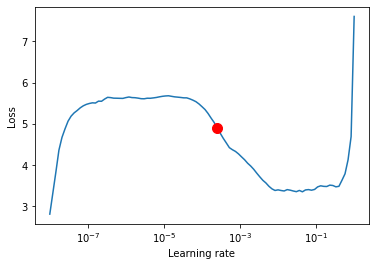

In [ ]:
config_model = {
    'lr' : 0.001,
    'dropout' : 0.2,
    'weight-decay': 3.1,
    'em-size' :256, # embedding dimension 
    'nhid' : 128, # the dimension of the feedforward network model in nn.TransformerEncoder
    'nlayers' :4, # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    'nhead' : 2, # the number of heads in the multiheadattention models
    'seq-len': config_data['seq-len'], # dont use wandb config 
    'vocab-size':len(dm.vocab.get_stoi()), # the size of vocabulary /also called tokens , stoi --> get_stoi()
    'weight_per_class':ws,
    "val-file":"val-out.txt",
    "train-file":'train-out.txt',
    "vocab": dm.vocab
}

with open (config_model["val-file"],'w') as f:
    f.write(">> Starting")

with open (config_model["train-file"],'w') as f:
    f.write(">> Starting")

# setup model - note how we refer to sweep parameters with wandb.config
model = TransformerModel(config=config_model).cuda()  # to(device)

early_stop_callback = EarlyStopping(
        monitor='val_epoch_loss',
        min_delta=0,
        patience=600,
        verbose=True,
        mode='min'
)


# enable_pl_optimizer=True,progress_bar_refresh_rate=0 - removed
trainer = Trainer(accelerator = "gpu",devices= 1,auto_lr_find=0.0001, precision=16, num_nodes=1,  max_epochs=100, check_val_every_n_epoch=1,deterministic=True,gradient_clip_val=0.5,callbacks=[early_stop_callback])

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model,dm)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"Suggested lr = {new_lr}")

In [ ]:
model.hparams.lr = new_lr/100 #7.5e-12 # can devide by 10
trainer.fit(model,dm) # Fit model

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                | Type                   | Params
----------------------------------------------------------------
0  | pos_encoder         | PositionalEncoding     | 0     
1  | transformer_encoder | TransformerEncoder     | 1.3 M 
2  | encoder             | Embedding              | 55.8 K
3  | decoder             | Linear                 | 56.0 K
4  | val_CM_normalized   | ConfusionMatrix        | 0     
5  | val_CM_raw          | ConfusionMatrix        | 0     
6  | train_CM_normalized | ConfusionMatrix        | 0     
7  | train_CM_raw        | ConfusionMatrix        | 0     
8  | test_CM             | ConfusionMatrix        | 0     
9  | val_MCR             | MyClassificationReport | 0     
10 | test_MCR            | MyClassificationReport | 0     
----------------------------------------------------------------
1.4 M     Trainable params
0   

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 28994 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 27250 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 30084 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 28122 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 23762 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 24852 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 26814 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 34880 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 41856 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: 23544 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/usr/local/lib/pytho

[0]E, Avg Training loss = 1.8193 

RuntimeError: ignored